# XGBoost_SHAP_Explain

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import joblib
from sklearn import metrics
from collections import Counter

In [2]:
rf_df_train = pd.read_csv('../data/train.csv')
rf_df_test = pd.read_csv('../data/val.csv')

X_train = rf_df_train.drop(['Class'], axis=1)
y_train = rf_df_train['Class']

X_test = rf_df_test.drop(['Class'], axis=1)
y_test = rf_df_test['Class']

# # 有挂你怎么玩
# X_train = pd.concat([X_train, X_test], axis=0, ignore_index=True)
# # 合并标签
# y_train = pd.concat([y_train, y_test], axis=0, ignore_index=True)

In [3]:
from sklearn.preprocessing import StandardScaler


# 创建一个函数来进行特征缩放
def Standard_Scaler(df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    return df


col_names = ['Amount']
X_train = Standard_Scaler(X_train, col_names)
X_test = Standard_Scaler(X_test, col_names)

In [4]:
from sklearn.model_selection import StratifiedKFold

#确保每次数据划分都是相同的。
#通过创建一个KFold对象kf，并将cv=kf传递进去，而不是常用的cv=5，来实现这一点。

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [5]:
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
#
# # 1. 创建XGBoost分类器
# # grid_xgb_model = XGBClassifier(random_state=13, eval_metric='logloss')
#
# # 定义参数网格
# params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [4, 6, 10],
#     'learning_rate': [0.01, 0.1, 0.2]
# }
#
# xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=13), param_grid=params, cv=5, n_jobs=-1)


In [6]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

# 定义模型时加random_state
model = xgb.XGBClassifier(random_state=13, eval_metric='logloss')

# 定义参数网格
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
# params = {
#     'n_estimators': [80, 100, 120, 150],
#     'max_depth': [8, 10, 12],
#     'learning_rate': [0.15, 0.18, 0.2, 0.25],
#     #'subsample': [0.8, 1.0],
#     #'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }


# GridSearchCV不要random_state
xgb_model = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)

In [7]:
# 2. 训练模型
xgb_model.fit(X_train, y_train)

# 输出最佳参数和分数
print('最佳参数:', xgb_model.best_params_)
print('最佳分数:', xgb_model.best_score_)

# 保存模型到文件
joblib.dump(xgb_model, '../models/best_xgb_model.pkl')

最佳参数: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
最佳分数: 0.9995686280113116


['../models/best_xgb_model.pkl']

In [8]:
y_pred = xgb_model.predict(X_test)

In [9]:
cm = confusion_matrix(y_test, y_pred)

xgb_recall = recall_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[56861     2]
 [   23    76]]


In [10]:
ndf = [(xgb_recall, xgb_precision, xgb_f1, xgb_accuracy)]

xgb_score = pd.DataFrame(data=ndf, columns=['Recall', 'Precision', 'F1 Score', 'Accuracy'])
xgb_score.insert(0, 'Models', 'XGBoost')
xgb_score

,Models,Recall,Precision,F1 Score,Accuracy
0,XGBoost,0.767677,0.974359,0.858757,0.999561


## 1 导入库

In [11]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2 加载模型与数据

In [12]:
import joblib
import shap
import pandas as pd

# 加载模型
grid_xgb_model = joblib.load('../models/grid_xgb_model.pkl')

# 取出最佳模型
xgb_model = grid_xgb_model.best_estimator_

import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)  # X为你的输入特征（和训练一致）

import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# 加载数据（以验证集为例）
X = pd.read_csv('../data/val.csv').drop('Class', axis=1)
# 若你对'Amount'做了标准化，需与训练标准一致，否则shap解释会错位
from sklearn.preprocessing import StandardScaler
# 创建一个函数来进行特征缩放
def Standard_Scaler(df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    return df

col_names = ['Amount']
X = Standard_Scaler(X, col_names)

# 可以选择前N行做局部解释
X_sample = X.sample(10, random_state=42) # 随机采样10行做局部解释（可自定义）

NameError: name 'best_model' is not defined

## 4 SHAP解释

### 4.1 初始化SHAP解释器

In [468]:
explainer = shap.TreeExplainer(xgb_model)
# 计算SHAP值
shap_values = explainer.shap_values(X)

### 4.2 全局解释：特征重要性

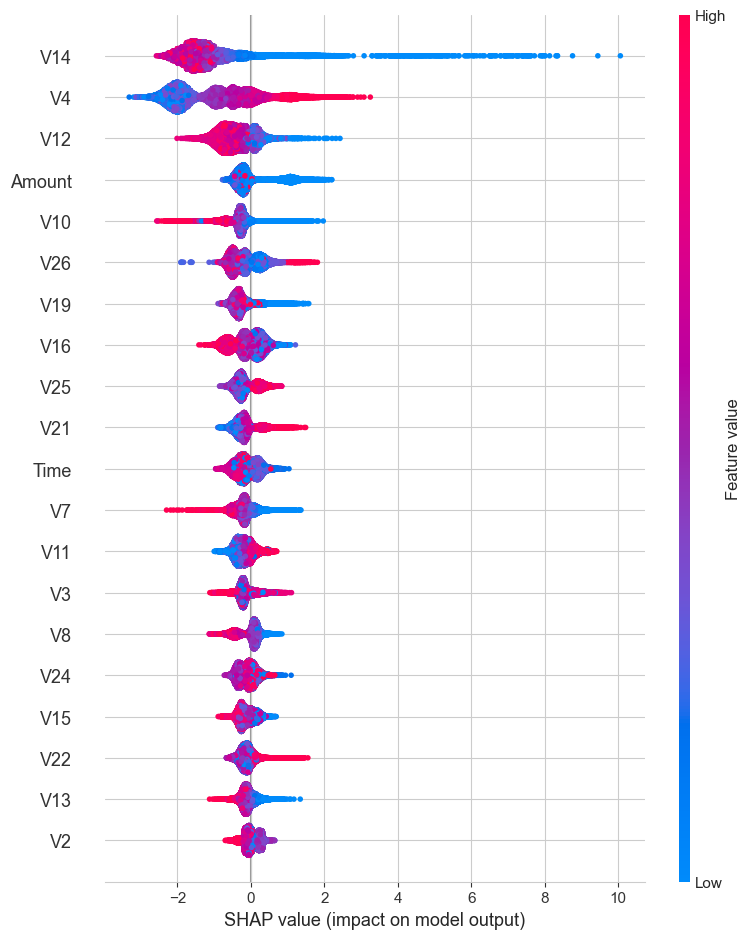

In [469]:
shap.summary_plot(shap_values, X)  # 经典的蜂群图/特征重要性


### 4.3 局部解释：单个样本的预测解释

In [470]:
# 以第一个样本为例
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

### 4.4 局部解释：多个样本的预测解释

In [471]:
# 选择前10个样本
shap.force_plot(explainer.expected_value, shap_values[:10, :], X.iloc[:10, :])

## 5 SHAP依赖图：展示特征与预测的关系

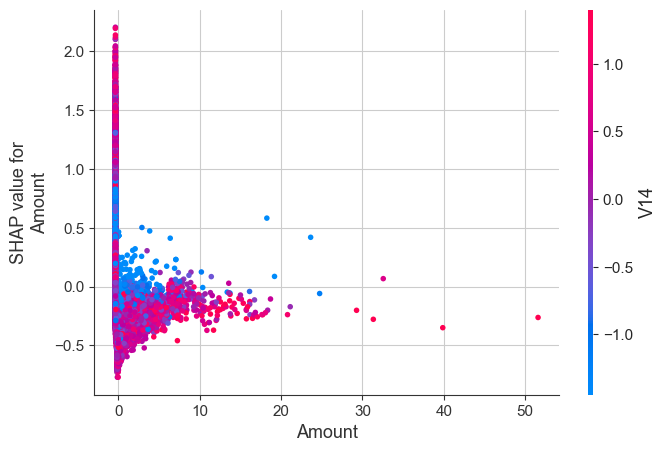

In [472]:
# 对某个特征（如'Amount'），可展示其与SHAP值的关系
shap.dependence_plot('Amount', shap_values, X)

## 6 可视化SHAP值：条形图

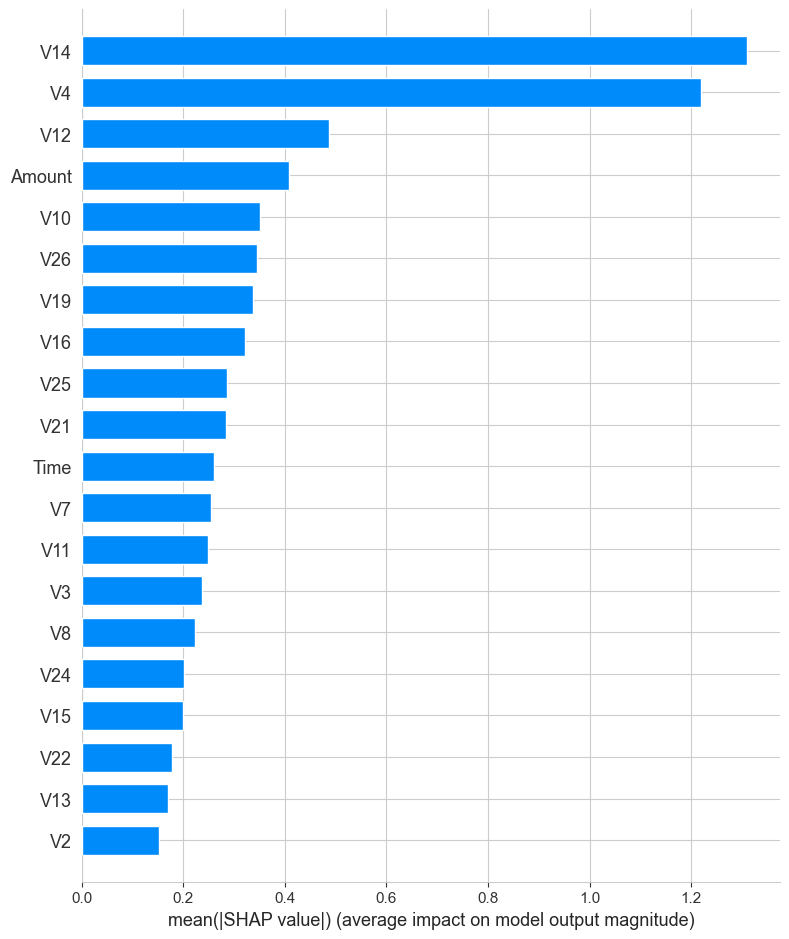

In [473]:
shap.summary_plot(shap_values, X, plot_type="bar")  # 条形图显示特征重要性

In [474]:
i = 0  # 选择你要解释的样本索引，比如第一个样本
shap.force_plot(explainer.expected_value, shap_values[i], X.iloc[i])